In [1]:
import tensorflow as tf
tf.reset_default_graph()

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
import matplotlib.pyplot as plt

5


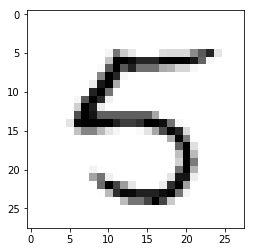

In [4]:
image, label = mnist.train.next_batch(1)
%matplotlib inline
print(label[0])
plt.imshow(image[0].reshape(28,28), cmap='Greys')

In [5]:
def discriminator(x, reuse=False):
    with tf.variable_scope("D"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        w1 = tf.get_variable("w1", [5, 5, 1, 32], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b1 = tf.get_variable("b1", [32], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h1 = tf.nn.relu(tf.nn.conv2d(x, w1, [1, 2, 2, 1], "SAME") + b1)
        
        w2 = tf.get_variable("w2", [5, 5, 32, 64], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable("b2", [64], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h2 = tf.nn.relu(tf.nn.conv2d(h1, w2, [1, 2, 2, 1], "SAME") + b2)
        
        w3 = tf.get_variable("w3", [5, 5, 64, 128], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b3 = tf.get_variable("b3", [128], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h3 = tf.nn.relu(tf.nn.conv2d(h2, w3, [1, 2, 2, 1], "SAME") + b3)
                
        w4 = tf.get_variable("w4", [5, 5, 128, 256], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b4 = tf.get_variable("b4", [256], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h4 = tf.nn.relu(tf.nn.conv2d(h3, w4, [1, 2, 2, 1], "SAME") + b4)
        h4 = tf.reshape(h4, [-1, 256])
        
        w5 = tf.get_variable("w5", [256, 1], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b5 = tf.get_variable("b5", [1], initializer = tf.truncated_normal_initializer(stddev=0.02))
        return tf.matmul(h4, w5) + b5

In [6]:
def generator(z, zdim, batch_size, reuse=False):
    with tf.variable_scope("G"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()

        w1 = tf.get_variable("w1", [zdim, 28 * 28 * 4], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b1 = tf.get_variable("b1", [28 * 28 * 4], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h1 = tf.nn.relu(tf.matmul(z, w1) + b1)
        h1 = tf.reshape(h1, [batch_size, 28 * 2, 28 * 2, 1])

        w2 = tf.get_variable("w2", [5, 5, 1, zdim/2], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable("b2", [zdim/2], initializer = tf.truncated_normal_initializer(stddev=0.02))
        bn2 = tf.nn.conv2d(h1, w2, [1, 2, 2, 1], "SAME") + b2
        h2 = tf.nn.relu(bn2)
        h2 = tf.image.resize_images(h2, [28*2, 28*2])
        
        
        w3 = tf.get_variable("w3", [5, 5, zdim/2, zdim/4], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b3 = tf.get_variable("b3", [zdim/4], initializer = tf.truncated_normal_initializer(stddev=0.02))
        bn3 = tf.nn.conv2d(h2, w3, [1, 2, 2, 1], "SAME") + b3
        h3 = tf.nn.relu(bn3)
        h3 = tf.image.resize_images(h3, [28*2, 28*2])

        w4 = tf.get_variable("w4", [1, 1, zdim/4, 1], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b4 = tf.get_variable("b4", [1], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h4 = tf.nn.conv2d(h3, w4, [1, 2, 2, 1], "SAME") + b4
        return tf.sigmoid(h4)


In [7]:
x_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1], name="x")
z_placeholder = tf.placeholder(tf.float32, [None, None], name="z")

In [8]:
session = tf.Session()
Dx = discriminator(x_placeholder)
Gz = generator(z_placeholder, 100, 100, False)
Dg = discriminator(Gz, True)

In [9]:
d_cost_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_cost_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
g_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [10]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'D/' in var.name]
g_vars = [var for var in tvars if 'G/' in var.name]

In [ ]:
optimizer_d_real = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_real, var_list=d_vars)
optimizer_d_fake = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_fake, var_list=d_vars)
optimizer_g = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_cost, var_list=g_vars)

0
d_loss_real:
0.701517
d_loss_fake:
0.703817


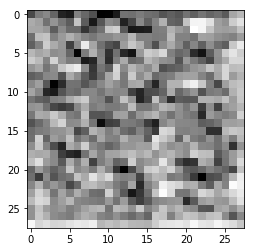

20
d_loss_real:
0.633668
d_loss_fake:
0.736021
40
d_loss_real:
0.352832
d_loss_fake:
1.41746
60
d_loss_real:
0.294403
d_loss_fake:
2.1616
80
d_loss_real:
0.529152
d_loss_fake:
1.19412
100
d_loss_real:
0.0316458
d_loss_fake:
0.255558


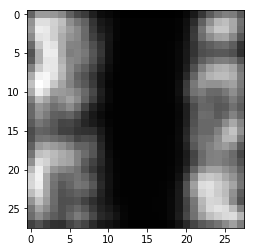

120
d_loss_real:
0.365186
d_loss_fake:
4.09053
140
d_loss_real:
0.0629749
d_loss_fake:
0.856923
160
d_loss_real:
0.0495427
d_loss_fake:
0.855158
180
d_loss_real:
0.00294395
d_loss_fake:
0.0940941
200
d_loss_real:
0.0015461
d_loss_fake:
0.0191108


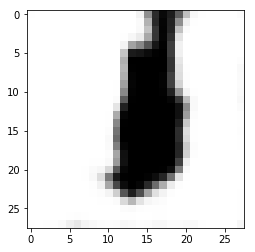

220
d_loss_real:
0.0124927
d_loss_fake:
0.460762
240
d_loss_real:
0.0355032
d_loss_fake:
1.19721
260
d_loss_real:
0.00487332
d_loss_fake:
0.0398066
280
d_loss_real:
0.0121097
d_loss_fake:
0.911669
300
d_loss_real:
1.15797
d_loss_fake:
12.5209


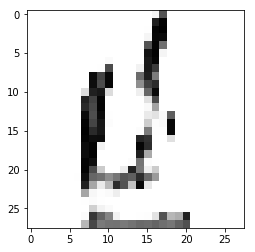

320
d_loss_real:
1.70293
d_loss_fake:
1.06634
340
d_loss_real:
1.72651
d_loss_fake:
7.27165
360
d_loss_real:
0.000575322
d_loss_fake:
0.131852
380
d_loss_real:
14.8317
d_loss_fake:
10.4393
400
d_loss_real:
1.22527
d_loss_fake:
10.5041


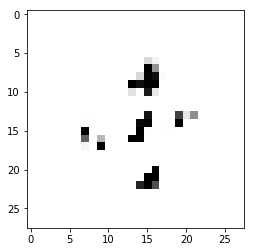

420
d_loss_real:
0.339749
d_loss_fake:
2.25886
440
d_loss_real:
8.7261
d_loss_fake:
12.9731
460
d_loss_real:
0.0717572
d_loss_fake:
4.47015
480
d_loss_real:
12.68
d_loss_fake:
18.0715
500
d_loss_real:
9.2421
d_loss_fake:
6.39056


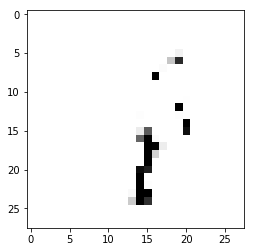

520
d_loss_real:
0.68504
d_loss_fake:
1.81111
540
d_loss_real:
17.9405
d_loss_fake:
4.35729
560
d_loss_real:
9.9873
d_loss_fake:
5.03752
580
d_loss_real:
2.39712
d_loss_fake:
6.98997


In [ ]:
import numpy as np
import datetime
session.run(tf.global_variables_initializer())

batch_size = 100
z_dimensions = 100
for i in range(10000):
    real_image_batch, _ = mnist.train.next_batch(batch_size)
    real_image_batch = real_image_batch.reshape([-1, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _, __, d_loss_real, d_loss_fake = session.run([optimizer_d_real, optimizer_d_fake, d_cost_real, d_cost_fake],
                                           {x_placeholder: real_image_batch, z_placeholder:z_batch})
    
    _ = session.run([optimizer_g], feed_dict={z_placeholder:z_batch})

    if i % 20 == 0:
        print i
        print "d_loss_real:"
        print d_loss_real
        print "d_loss_fake:"
        print d_loss_fake
    if i % 100 == 0:
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, z_dimensions, 1, True)
        images = session.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()